# 🚀 Обучение и Сравнение ML Моделей

**Задача:** Store Item Demand Forecasting  
**Целевая переменная:** `sales`  
**Тип задачи:** Регрессия временных рядов  
**Метрика:** SMAPE

**Цель:** Систематически обучить, сравнить и проанализировать несколько моделей машинного обучения, выбрать лучшую и определить дальнейшие шаги.

**Примечание:** 
- Используются очищенные фичи (`train_features_cleaned.csv` и `test_features_cleaned.csv`) 
- Избыточные фичи удалены для улучшения производительности и интерпретируемости
- Test данные загружаются из отдельного файла `test_features_cleaned.csv`
- Для разделения train/validation используется **TimeSeriesSplit по годам**
- TimeSeriesSplit гарантирует временной порядок: train всегда предшествует validation

**Workflow:**
1. Загрузка и подготовка данных (TimeSeriesSplit для train/val, отдельный файл для test)
2. Бейзлайн: ARIMA
3. ML модели: LightGBM, XGBoost, RandomForest
4. Сравнение моделей и анализ важности фичей
5. Сохранение лучшей модели

## 📦 Импорты и настройка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
import joblib

warnings.filterwarnings('ignore')

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Настройка воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Импорты моделей
from src.data.load_data import load_train
from src.data.save_data import load_dataframe
from src.features.build_features import build_features_for_test
from src.models import (
    prepare_data_for_training,
    ARIMABaseline,
    train_model,
    create_default_models,
    train_models_with_cv,
    compare_models,
    get_feature_importance,
    save_model,
    load_model,
    calculate_regression_metrics,
    smape
)

from sklearn.model_selection import TimeSeriesSplit

print("=" * 80)
print("🚀 ОБУЧЕНИЕ И СРАВНЕНИЕ ML МОДЕЛЕЙ")
print("=" * 80)

🚀 ОБУЧЕНИЕ И СРАВНЕНИЕ ML МОДЕЛЕЙ


---

## 📥 ЧАСТЬ 1: ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ

### 1.1 Загрузка данных с фичами

In [2]:
# Загрузка данных с очищенными фичами (избыточные фичи удалены)
train_features_file = project_root / 'data' / 'processed' / 'train_features_cleaned.csv'
test_features_file = project_root / 'data' / 'processed' / 'test_features_cleaned.csv'

# Загрузка train данных (включает train + validation части)
if train_features_file.exists():
    print(f"📥 Загрузка train_features_cleaned.csv...")
    train_full = load_dataframe(train_features_file, verbose=False)
    print(f"✅ Загружено {train_full.shape[0]:,} строк")
    print(f"💡 Используются очищенные фичи (избыточные удалены)")
else:
    # Fallback на полный набор фичей, если очищенные не найдены
    fallback_file = project_root / 'data' / 'processed' / 'train_features.csv'
    if fallback_file.exists():
        print(f"⚠️ train_features_cleaned.csv не найден. Используем train_features.csv...")
        print(f"   Рекомендуется создать очищенные фичи в ноутбуке 01 для лучшей производительности")
        train_full = load_dataframe(fallback_file, verbose=False)
        print(f"✅ Загружено {train_full.shape[0]:,} строк")
    else:
        raise FileNotFoundError(f"Файлы с фичами не найдены! Сначала создайте фичи в ноутбуке 01.")

# Загрузка test данных (отдельный файл)
if test_features_file.exists():
    print(f"\n📥 Загрузка test_features_cleaned.csv...")
    test_full = load_dataframe(test_features_file, verbose=False)
    print(f"✅ Загружено {test_full.shape[0]:,} строк")
else:
    # Fallback на полный набор фичей
    fallback_test_file = project_root / 'data' / 'processed' / 'test_features.csv'
    if fallback_test_file.exists():
        print(f"\n⚠️ test_features_cleaned.csv не найден. Используем test_features.csv...")
        test_full = load_dataframe(fallback_test_file, verbose=False)
        print(f"✅ Загружено {test_full.shape[0]:,} строк")
    else:
        print(f"\n⚠️ test_features.csv не найден. Test будет пустым.")
        test_full = None

# Преобразуем колонку date в datetime
if train_full['date'].dtype == 'object' or isinstance(train_full['date'].iloc[0], str):
    train_full['date'] = pd.to_datetime(train_full['date'])

if test_full is not None:
    if test_full['date'].dtype == 'object' or isinstance(test_full['date'].iloc[0], str):
        test_full['date'] = pd.to_datetime(test_full['date'])

# Сортируем train_full по дате для TimeSeriesSplit
train_full = train_full.sort_values('date').reset_index(drop=True)

# Используем TimeSeriesSplit для разделения train/validation по годам
print(f"\n📊 Разделение данных с помощью TimeSeriesSplit...")
print(f"   Период train данных: {train_full['date'].min()} → {train_full['date'].max()}")

# Создаем TimeSeriesSplit для разделения по годам
# Используем последний фолд для получения train/validation split
tscv = TimeSeriesSplit(n_splits=5)

# Получаем индексы для последнего фолда (максимальное использование данных)
train_indices = None
val_indices = None

for train_idx, val_idx in tscv.split(train_full):
    train_indices = train_idx
    val_indices = val_idx

# Разделяем данные
train_df = train_full.iloc[train_indices].copy()
val_df = train_full.iloc[val_indices].copy()

# Test берем из отдельного файла
if test_full is not None:
    test_df = test_full.copy()
else:
    # Fallback: пытаемся взять из train_full (если там есть данные после validation)
    val_end_date = val_df['date'].max()
    test_df = train_full[train_full['date'] > val_end_date].copy() if len(train_full[train_full['date'] > val_end_date]) > 0 else pd.DataFrame()

print(f"\n📊 Разделение данных (TimeSeriesSplit):")
print(f"   Train: {len(train_df):,} записей ({train_df['date'].min()} → {train_df['date'].max()})")
print(f"   Validation: {len(val_df):,} записей ({val_df['date'].min()} → {val_df['date'].max()})")
if test_df is not None and len(test_df) > 0:
    print(f"   Test: {len(test_df):,} записей ({test_df['date'].min()} → {test_df['date'].max()})")
else:
    print(f"   Test: 0 записей (файл не найден или пуст)")

# Показываем распределение по годам
print(f"\n📅 Распределение по годам:")
print(f"   Train годы: {sorted(train_df['date'].dt.year.unique())}")
print(f"   Validation годы: {sorted(val_df['date'].dt.year.unique())}")
if test_df is not None and len(test_df) > 0:
    print(f"   Test годы: {sorted(test_df['date'].dt.year.unique())}")

📥 Загрузка train_features_cleaned.csv...
✅ Загружено 684,500 строк
💡 Используются очищенные фичи (избыточные удалены)

📥 Загрузка test_features_cleaned.csv...
✅ Загружено 45,000 строк

📊 Разделение данных с помощью TimeSeriesSplit...
   Период train данных: 2013-01-01 00:00:00 → 2016-09-30 00:00:00

📊 Разделение данных (TimeSeriesSplit):
   Train: 570,417 записей (2013-01-01 00:00:00 → 2016-02-15 00:00:00)
   Validation: 114,083 записей (2016-02-15 00:00:00 → 2016-09-30 00:00:00)
   Test: 45,000 записей (2018-01-01 00:00:00 → 2018-03-31 00:00:00)

📅 Распределение по годам:
   Train годы: [np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016)]
   Validation годы: [np.int32(2016)]
   Test годы: [np.int32(2018)]


### 1.2 Подготовка данных для обучения

In [3]:
# Подготовка данных (предотвращение data leakage: статистики вычисляются только на train)
X_train, y_train, X_val, y_val, X_test, y_test, feature_names = prepare_data_for_training(
    train_df=train_df,
    val_df=val_df if len(val_df) > 0 else None,
    test_df=test_df if test_df is not None and len(test_df) > 0 else None,
    target_col='sales'
)

print(f"\n✅ Данные подготовлены:")
print(f"   Train: X={X_train.shape}, y={y_train.shape}")
if X_val is not None:
    print(f"   Validation: X={X_val.shape}, y={y_val.shape}")
else:
    print(f"   Validation: пусто (используйте TimeSeriesSplit для кросс-валидации)")
if X_test is not None:
    print(f"   Test: X={X_test.shape}, y={y_test.shape if y_test is not None else 'N/A'}")
    if y_test is None:
        print(f"   💡 Test не содержит sales - используется только для финальных предсказаний")
else:
    print(f"   Test: не загружен")
print(f"\n📈 Всего фичей: {len(feature_names)}")
print(f"   Примеры: {feature_names[:10]}")


✅ Данные подготовлены:
   Train: X=(570417, 62), y=(570417,)
   Validation: X=(114083, 62), y=(114083,)
   Test: X=(45000, 62), y=N/A
   💡 Test не содержит sales - используется только для финальных предсказаний

📈 Всего фичей: 62
   Примеры: ['id', 'year', 'day_of_week', 'day_of_month', 'quarter', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start']


---

## 📊 ЧАСТЬ 2: БЕЙЗЛАЙН - ARIMA

**Обоснование:** ARIMA (AutoRegressive Integrated Moving Average) - классическая модель для временных рядов. Используется как точка отсчета для сравнения с более сложными ML моделями.

In [4]:
print("=" * 80)
print("📊 ОБУЧЕНИЕ ARIMA BASELINE")
print("=" * 80)

# Создаем и обучаем ARIMA baseline
baseline_model = ARIMABaseline(order=(1, 1, 1), random_state=RANDOM_STATE)

print("\n🔄 Обучение ARIMA моделей для каждой (store, item) комбинации...")
baseline_model.fit(train_df, target_col='sales')

print(f"✅ Обучено {len(baseline_model.models)} ARIMA моделей")
print(f"   Всего комбинаций (store, item): {train_df.groupby(['store', 'item']).ngroups}")

📊 ОБУЧЕНИЕ ARIMA BASELINE

🔄 Обучение ARIMA моделей для каждой (store, item) комбинации...


c:\Users\teles\ml_projects\shop_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\teles\ml_projects\shop_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\teles\ml_projects\shop_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\teles\ml_projects\shop_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\teles\ml_projects\shop_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.p

✅ Обучено 500 ARIMA моделей
   Всего комбинаций (store, item): 500


In [5]:
# Предсказания на train и validation
print("\n📈 Предсказания на train...")
y_pred_train_baseline = baseline_model.predict(train_df)

# Метрики baseline на train
baseline_metrics_train = calculate_regression_metrics(y_train.values, y_pred_train_baseline)

print("\n📊 Метрики ARIMA Baseline:")
print("\nTrain:")
for metric, value in baseline_metrics_train.items():
    print(f"   {metric}: {value:.4f}")

# Метрики на validation (если есть данные)
if val_df is not None and len(val_df) > 0:
    print("\n📈 Предсказания на validation...")
    y_pred_val_baseline = baseline_model.predict(val_df)
    baseline_metrics_val = calculate_regression_metrics(y_val.values, y_pred_val_baseline)
    
    print("\nValidation:")
    for metric, value in baseline_metrics_val.items():
        print(f"   {metric}: {value:.4f}")
else:
    print("\n⚠️ Validation set пуст - метрики не вычислены")
    print("   Используйте TimeSeriesSplit для кросс-валидации")
    baseline_metrics_val = {}
    y_pred_val_baseline = None


📈 Предсказания на train...

📊 Метрики ARIMA Baseline:

Train:
   SMAPE: 199.8785
   RMSE: 55.0261
   MAE: 48.2554
   R²: -3.3321

📈 Предсказания на validation...

Validation:
   SMAPE: 199.3707
   RMSE: 69.2720
   MAE: 61.4955
   R²: -3.7378


---

## ✅ ЧАСТЬ 3: ПРЕДМОДЕЛЬНЫЙ ЧЕК-ЛИСТ

### 3.1 Стратегия кросс-валидации

**Выбор:** `TimeSeriesSplit`  
**Обоснование:** Данные представляют временные ряды, где порядок наблюдений критичен. `TimeSeriesSplit` гарантирует, что модель обучается на прошлых данных и валидируется на будущих, что предотвращает "заглядывание в будущее".

In [6]:
# Создаем стратегию кросс-валидации для использования внутри train части
# (train/validation уже разделены через TimeSeriesSplit в Cell 5)
tscv = TimeSeriesSplit(n_splits=5)

print(f"✅ Используем TimeSeriesSplit с {tscv.n_splits} фолдами")
print(f"   Это гарантирует временной порядок: train всегда предшествует validation")
print(f"\n💡 Примечание:")
print(f"   - Train/validation уже разделены через TimeSeriesSplit в Cell 5 (по годам)")
print(f"   - TimeSeriesSplit здесь используется для кросс-валидации внутри train части (опционально)")
print(f"   - Validation set (val_df) используется для финальной оценки после обучения")
print(f"   - Test set используется только для финальных предсказаний (без метрик)")

✅ Используем TimeSeriesSplit с 5 фолдами
   Это гарантирует временной порядок: train всегда предшествует validation

💡 Примечание:
   - Train/validation уже разделены через TimeSeriesSplit в Cell 5 (по годам)
   - TimeSeriesSplit здесь используется для кросс-валидации внутри train части (опционально)
   - Validation set (val_df) используется для финальной оценки после обучения
   - Test set используется только для финальных предсказаний (без метрик)


### 3.2 Проверка дисбаланса

**Примечание:** Для регрессии понятие "дисбаланс классов" не применимо. Однако стоит проверить распределение целевой переменной.

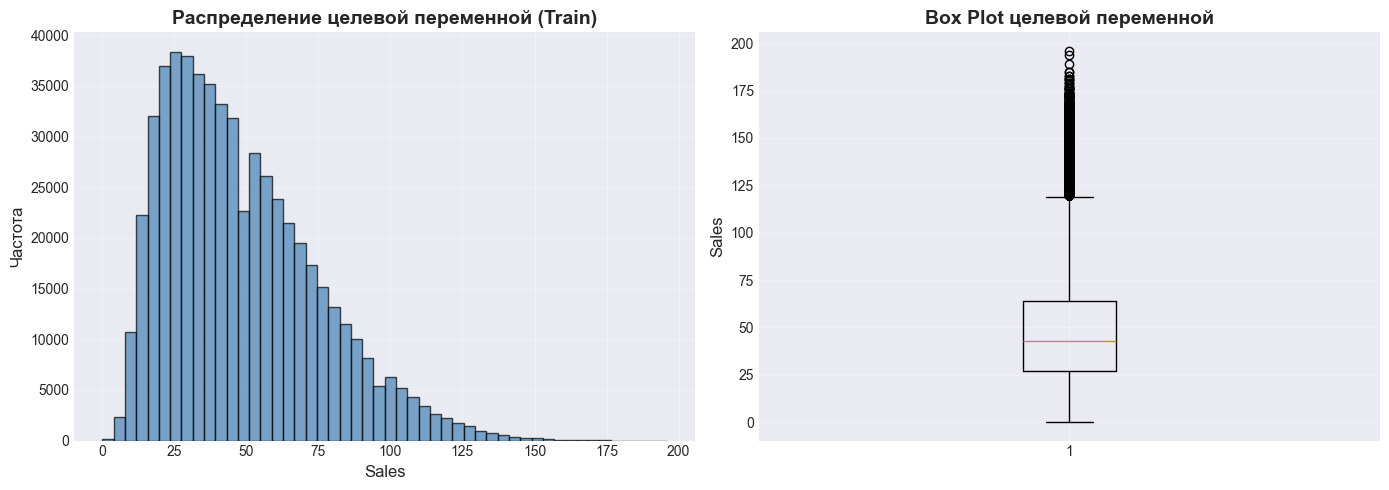

📊 Статистики целевой переменной (Train):
   Среднее: 48.26
   Медиана: 43.00
   Стандартное отклонение: 26.44
   Минимум: 0.00
   Максимум: 196.00


In [7]:
# Анализ распределения целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма
axes[0].hist(y_train.values, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Sales', fontsize=12)
axes[0].set_ylabel('Частота', fontsize=12)
axes[0].set_title('Распределение целевой переменной (Train)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(y_train.values, vert=True)
axes[1].set_ylabel('Sales', fontsize=12)
axes[1].set_title('Box Plot целевой переменной', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Статистики целевой переменной (Train):")
print(f"   Среднее: {y_train.mean():.2f}")
print(f"   Медиана: {y_train.median():.2f}")
print(f"   Стандартное отклонение: {y_train.std():.2f}")
print(f"   Минимум: {y_train.min():.2f}")
print(f"   Максимум: {y_train.max():.2f}")

### 3.3 Масштабирование признаков

**Выбор:** Не требуется для tree-based моделей (LightGBM, XGBoost, RandomForest)  
**Обоснование:** Деревья решений не требуют масштабирования признаков, так как работают с пороговыми значениями, а не с расстояниями.

### 3.4 Воспроизводимость результатов

**Установлено:** `RANDOM_STATE = 42`  
**Применяется:** Ко всем процессам (разделение данных, обучение моделей)

---

## 🤖 ЧАСТЬ 4: ОБУЧЕНИЕ ML МОДЕЛЕЙ

Обучаем несколько моделей градиентного бустинга и сравниваем их с baseline.

In [8]:
# Создаем модели
models_dict = create_default_models(random_state=RANDOM_STATE)

print(f"✅ Создано {len(models_dict)} моделей:")
for name in models_dict.keys():
    print(f"   - {name}")

✅ Создано 3 моделей:
   - LightGBM
   - XGBoost
   - RandomForest


In [9]:
# Обучение всех моделей
print("=" * 80)
print("🔄 ОБУЧЕНИЕ МОДЕЛЕЙ")
print("=" * 80)

if X_val is None or len(X_val) == 0:
    print("\n⚠️ ВНИМАНИЕ: Validation set пуст!")
    print("   Модели будут обучаться только на train данных")
    print("   Рекомендуется использовать TimeSeriesSplit для кросс-валидации")

trained_models = {}
results_dict = {}

for model_name, model in models_dict.items():
    print(f"\n{'='*80}")
    print(f"🎯 {model_name}")
    print(f"{'='*80}")
    
    model_fitted, metrics, y_pred_train, y_pred_val = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val if X_val is not None and len(X_val) > 0 else None,
        y_val=y_val if y_val is not None and len(y_val) > 0 else None,
        random_state=RANDOM_STATE
    )
    
    trained_models[model_name] = model_fitted
    results_dict[model_name] = {
        'model': model_fitted,
        'metrics': metrics,
        'y_pred_train': y_pred_train,
        'y_pred_val': y_pred_val
    }
    
    print(f"\n📊 Результаты {model_name}:")
    print(f"   Train SMAPE: {metrics.get('train_SMAPE', 0):.4f}")
    if 'val_SMAPE' in metrics:
        print(f"   Val SMAPE: {metrics.get('val_SMAPE', 0):.4f}")
        print(f"   Val RMSE: {metrics.get('val_RMSE', 0):.4f}")
        print(f"   Val R²: {metrics.get('val_R²', 0):.4f}")
    else:
        print(f"   Val SMAPE: N/A (validation set пуст)")

🔄 ОБУЧЕНИЕ МОДЕЛЕЙ

🎯 LightGBM

📊 Результаты LightGBM:
   Train SMAPE: 13.2971
   Val SMAPE: 11.7395
   Val RMSE: 8.2327
   Val R²: 0.9331

🎯 XGBoost

📊 Результаты XGBoost:
   Train SMAPE: 13.0975
   Val SMAPE: 11.7555
   Val RMSE: 8.2929
   Val R²: 0.9321

🎯 RandomForest

📊 Результаты RandomForest:
   Train SMAPE: 13.3242
   Val SMAPE: 11.8950
   Val RMSE: 8.4346
   Val R²: 0.9298


In [10]:
# Добавляем baseline в результаты
if baseline_metrics_val:
    results_dict['ARIMA_Baseline'] = {
        'model': baseline_model,
        'metrics': {
            'train_SMAPE': baseline_metrics_train['SMAPE'],
            'val_SMAPE': baseline_metrics_val['SMAPE'],
            'train_RMSE': baseline_metrics_train['RMSE'],
            'val_RMSE': baseline_metrics_val['RMSE'],
            'train_R²': baseline_metrics_train['R²'],
            'val_R²': baseline_metrics_val['R²']
        },
        'y_pred_train': y_pred_train_baseline,
        'y_pred_val': y_pred_val_baseline
    }
else:
    # Если validation пуст, добавляем только train метрики
    results_dict['ARIMA_Baseline'] = {
        'model': baseline_model,
        'metrics': {
            'train_SMAPE': baseline_metrics_train['SMAPE'],
            'train_RMSE': baseline_metrics_train['RMSE'],
            'train_R²': baseline_metrics_train['R²']
        },
        'y_pred_train': y_pred_train_baseline,
        'y_pred_val': None
    }
    print("\n⚠️ Baseline добавлен только с train метриками (validation пуст)")

# Создаем таблицу сравнения
comparison_data = []
for model_name, result in results_dict.items():
    metrics = result['metrics']
    comparison_data.append({
        'Model': model_name,
        'Train SMAPE': metrics.get('train_SMAPE', 0),
        'Val SMAPE': metrics.get('val_SMAPE', None) if 'val_SMAPE' in metrics else None,
        'Val RMSE': metrics.get('val_RMSE', None) if 'val_RMSE' in metrics else None,
        'Val R²': metrics.get('val_R²', None) if 'val_R²' in metrics else None
    })

comparison_df = pd.DataFrame(comparison_data)
# Сортируем по Val SMAPE, если есть, иначе по Train SMAPE
if comparison_df['Val SMAPE'].notna().any():
    comparison_df = comparison_df.sort_values('Val SMAPE')
else:
    comparison_df = comparison_df.sort_values('Train SMAPE')

print("=" * 80)
print("📊 СРАВНЕНИЕ МОДЕЛЕЙ")
print("=" * 80)
print("\n" + comparison_df.to_string(index=False))

📊 СРАВНЕНИЕ МОДЕЛЕЙ

         Model  Train SMAPE  Val SMAPE  Val RMSE    Val R²
      LightGBM    13.297097  11.739494  8.232714  0.933081
       XGBoost    13.097549  11.755539  8.292947  0.932098
  RandomForest    13.324239  11.894954  8.434554  0.929760
ARIMA_Baseline   199.878478 199.370710 69.271963 -3.737815


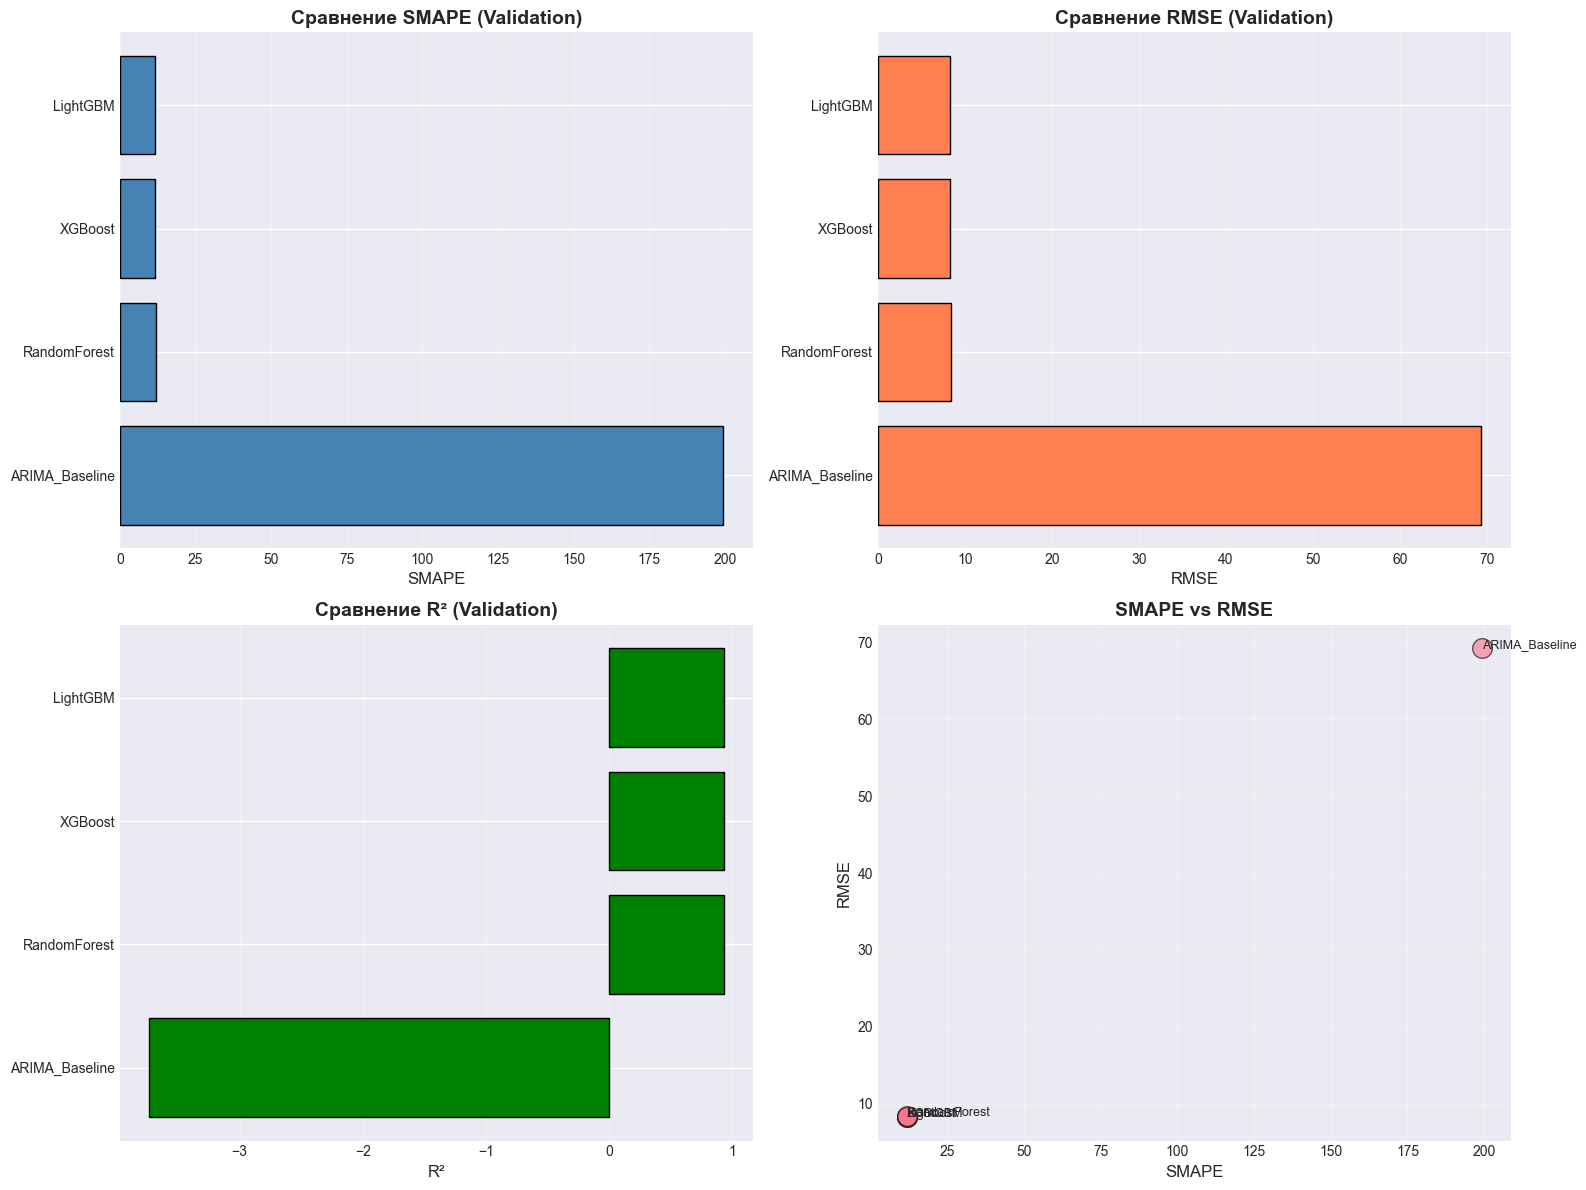

In [11]:
# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# SMAPE сравнение
axes[0, 0].barh(comparison_df['Model'], comparison_df['Val SMAPE'], color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('SMAPE', fontsize=12)
axes[0, 0].set_title('Сравнение SMAPE (Validation)', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# RMSE сравнение
axes[0, 1].barh(comparison_df['Model'], comparison_df['Val RMSE'], color='coral', edgecolor='black')
axes[0, 1].set_xlabel('RMSE', fontsize=12)
axes[0, 1].set_title('Сравнение RMSE (Validation)', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# R² сравнение
axes[1, 0].barh(comparison_df['Model'], comparison_df['Val R²'], color='green', edgecolor='black')
axes[1, 0].set_xlabel('R²', fontsize=12)
axes[1, 0].set_title('Сравнение R² (Validation)', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Scatter: SMAPE vs RMSE
axes[1, 1].scatter(comparison_df['Val SMAPE'], comparison_df['Val RMSE'], s=200, alpha=0.6, edgecolors='black')
for idx, row in comparison_df.iterrows():
    axes[1, 1].annotate(row['Model'], (row['Val SMAPE'], row['Val RMSE']), fontsize=9)
axes[1, 1].set_xlabel('SMAPE', fontsize=12)
axes[1, 1].set_ylabel('RMSE', fontsize=12)
axes[1, 1].set_title('SMAPE vs RMSE', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 📈 ЧАСТЬ 5: АНАЛИЗ ВАЖНОСТИ ФИЧЕЙ

Анализируем, какие фичи наиболее важны для лучшей модели.

🏆 Лучшая модель: LightGBM
   Val SMAPE: 11.7395

📊 Топ-20 важных фичей:
                 feature  importance
      seasonal_component         399
             day_of_week         341
            sales_lag_14         229
mean_sales_by_store_item         183
                    year         166
            day_of_month         158
             sales_lag_7         134
         cos_day_of_year         129
            lag_diff_7_1         124
           sales_lag_365          90
               sin_month          84
     days_to_quarter_end          83
           lag_diff_30_7          70
  rolling_diff_mean_30_7          66
             sales_lag_2          58
sales_to_store_item_mean          46
         item_month_mean          45
          rolling_std_30          44
           item_dow_mean          42
         store_month_std          39


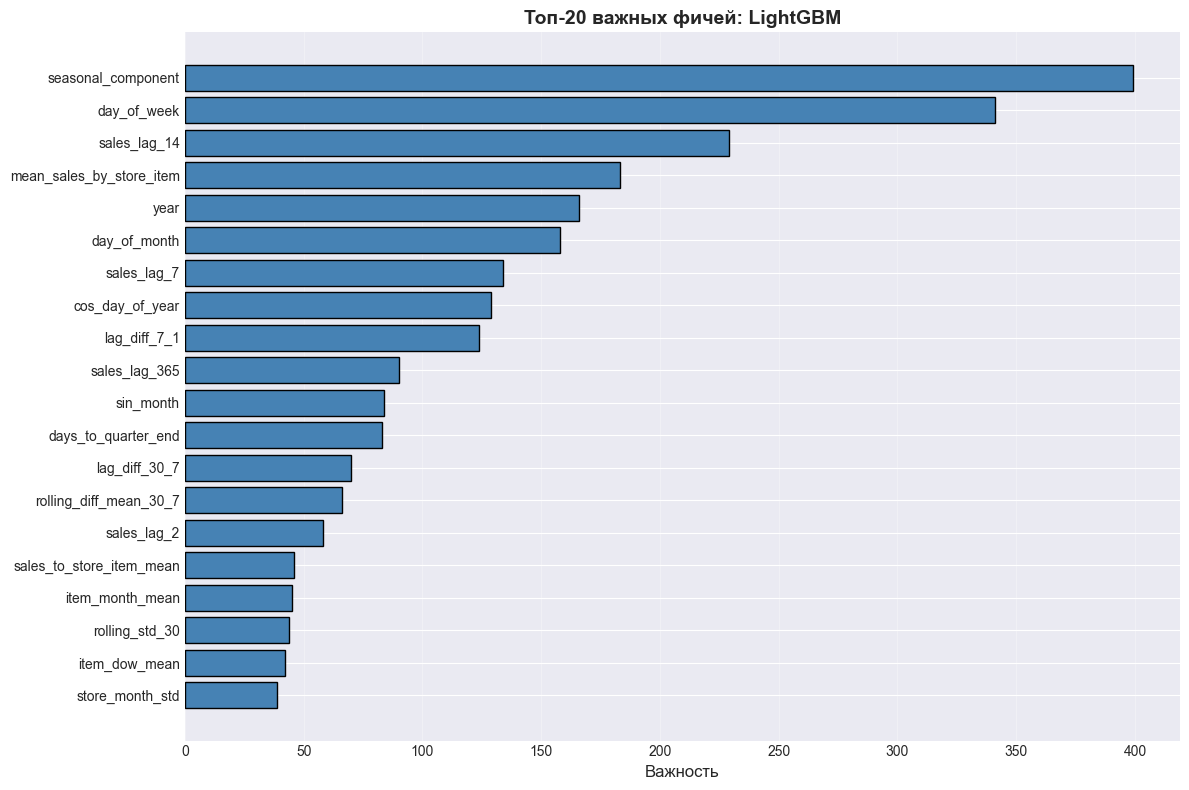


💡 Интерпретация:
   Наиболее важные фичи: seasonal_component, day_of_week, sales_lag_14, mean_sales_by_store_item, year


In [12]:
# Находим лучшую модель (по SMAPE на validation)
best_model_name = comparison_df.iloc[0]['Model']
best_model = results_dict[best_model_name]['model']

print(f"🏆 Лучшая модель: {best_model_name}")
print(f"   Val SMAPE: {comparison_df.iloc[0]['Val SMAPE']:.4f}")

# Анализ важности фичей (только для tree-based моделей)
if best_model_name != 'ARIMA_Baseline':
    feature_importance = get_feature_importance(best_model, feature_names, top_n=20)
    
    print(f"\n📊 Топ-20 важных фичей:")
    print(feature_importance.to_string(index=False))
    
    # Визуализация
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(range(len(feature_importance)), feature_importance['importance'].values, 
            color='steelblue', edgecolor='black')
    ax.set_yticks(range(len(feature_importance)))
    ax.set_yticklabels(feature_importance['feature'].values)
    ax.set_xlabel('Важность', fontsize=12)
    ax.set_title(f'Топ-20 важных фичей: {best_model_name}', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print(f"\n💡 Интерпретация:")
    print(f"   Наиболее важные фичи: {', '.join(feature_importance.head(5)['feature'].tolist())}")
else:
    print("\n⚠️ ARIMA не поддерживает feature importance для всех фичей сразу.")

---

## 🤔 ЧАСТЬ 6: АНАЛИЗ, САМОКРИТИКА И СЛЕДУЮЩИЕ ШАГИ

### 6.1 Сводный анализ

In [13]:
print("=" * 80)
print("📊 СВОДНЫЙ АНАЛИЗ")
print("=" * 80)

best_smape = comparison_df.iloc[0]['Val SMAPE']
baseline_smape = comparison_df[comparison_df['Model'] == 'ARIMA_Baseline']['Val SMAPE'].iloc[0]
improvement = ((baseline_smape - best_smape) / baseline_smape) * 100

print(f"\n🏆 Лучшая модель: {best_model_name}")
print(f"   Validation SMAPE: {best_smape:.4f}")
print(f"\n📊 Сравнение с Baseline:")
print(f"   ARIMA Baseline SMAPE: {baseline_smape:.4f}")
print(f"   Улучшение: {improvement:.2f}%")
print(f"   Абсолютное улучшение: {baseline_smape - best_smape:.4f}")

if improvement > 5:
    print(f"\n✅ Улучшение значимое ({improvement:.2f}%) - усложнение модели оправдано!")
else:
    print(f"\n⚠️ Улучшение незначительное ({improvement:.2f}%) - возможно, стоит вернуться к более простым моделям.")

📊 СВОДНЫЙ АНАЛИЗ

🏆 Лучшая модель: LightGBM
   Validation SMAPE: 11.7395

📊 Сравнение с Baseline:
   ARIMA Baseline SMAPE: 199.3707
   Улучшение: 94.11%
   Абсолютное улучшение: 187.6312

✅ Улучшение значимое (94.11%) - усложнение модели оправдано!


### 6.2 Самокритика

Потенциальные слабости подхода:
1. **Гиперпараметры по умолчанию:** Использованы стандартные параметры моделей, возможно нужен тюнинг
2. **Ограниченный набор моделей:** Рассмотрены только tree-based модели, можно попробовать нейросети
3. **Feature engineering:** Возможно, стоит создать дополнительные фичи на основе анализа важности
4. **Временная валидация:** Использован TimeSeriesSplit, но можно рассмотреть более сложные стратегии

### 6.3 Следующие шаги

**Рекомендация:** Гиперпараметрический тюнинг лучшей модели

**Стратегия:**
1. Использовать `Optuna` или `GridSearchCV` для поиска оптимальных гиперпараметров
2. Ключевые параметры для тюнинга:
   - Для LightGBM/XGBoost: `learning_rate`, `max_depth`, `n_estimators`, `subsample`
   - Для RandomForest: `n_estimators`, `max_depth`, `min_samples_split`
3. Использовать TimeSeriesSplit для валидации при тюнинге
4. Метрика оптимизации: SMAPE

**Альтернативные направления:**
- Feature Engineering: Создать новые фичи на основе топ важных (взаимодействия, полиномы)
- Error Analysis: Проанализировать объекты с наибольшими ошибками, найти закономерности

---

## 💾 ЧАСТЬ 7: СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ

In [14]:
# Сохранение лучшей модели
artifacts_dir = project_root / 'artifacts' / 'models'
artifacts_dir.mkdir(parents=True, exist_ok=True)

# Формируем имя файла с метрикой
smape_value = comparison_df.iloc[0]['Val SMAPE']
model_filename = f"{best_model_name.lower().replace(' ', '_')}_smape_{smape_value:.2f}.joblib"
model_path = artifacts_dir / model_filename

# Сохраняем модель
save_model(
    model=best_model,
    filepath=model_path,
    metrics=results_dict[best_model_name]['metrics'],
    feature_names=feature_names
)

print(f"\n✅ Лучшая модель сохранена:")
print(f"   Путь: {model_path}")
print(f"   Модель: {best_model_name}")
print(f"   SMAPE: {smape_value:.4f}")

✅ Модель сохранена: C:\Users\teles\ml_projects\shop_project\artifacts\models\lightgbm_smape_11.74.joblib
   Метаданные: C:\Users\teles\ml_projects\shop_project\artifacts\models\lightgbm_smape_11.74.json

✅ Лучшая модель сохранена:
   Путь: C:\Users\teles\ml_projects\shop_project\artifacts\models\lightgbm_smape_11.74.joblib
   Модель: LightGBM
   SMAPE: 11.7395


In [15]:
# Проверка загрузки модели
print("\n🔍 Проверка загрузки модели...")
loaded_model, metadata = load_model(model_path)

print(f"✅ Модель успешно загружена")
if metadata:
    print(f"   Метрики:")
    for key, value in metadata.get('metrics', {}).items():
        print(f"     {key}: {value:.4f}")
    print(f"   Количество фичей: {len(metadata.get('feature_names', []))}")


🔍 Проверка загрузки модели...
✅ Модель успешно загружена
   Метрики:
     train_SMAPE: 13.2971
     train_RMSE: 7.0954
     train_MAE: 5.4684
     train_R²: 0.9280
     val_SMAPE: 11.7395
     val_RMSE: 8.2327
     val_MAE: 6.3109
     val_R²: 0.9331
   Количество фичей: 62
